# Initial Steps: load packages, files and functions

In [11]:
import pandas as pd
import urllib
import time
import requests
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [12]:
cwd=os.getcwd()
cwd_Raw_Data_outputs=os.path.join(cwd,'RawData')#heres where we store freezes of the raw data
cwd_Figures=os.path.join(cwd,'Figures')#figures and code for generating them can go here
cwd_Output=os.path.join(cwd,'Output Dataframes')

In [13]:
dfSynonym=pd.read_excel(os.path.join(cwd,'Synonyms_filtered_v3.xlsx'),engine="openpyxl")
dfSynonym=dfSynonym.sort_values(by="Symbol")
dfSynonym=dfSynonym.reset_index()
dfSynonym=dfSynonym.drop(columns="index")
dfSynonym.index=dfSynonym["Symbol"]

In [14]:
gene_terms=str("(\"+_gene_+\"[ti])")
CT1_queryPM=str("")
CT1_queryNIH=str("")

In [15]:
def GetAwardAmount(input_String, Lists):
    #function takes three arguments; the Reporter output, the destination where we store results, and an additional list for storing a freeze of the data
    GetResults = input_String.find("\"results\"") #find the part of the output detailing grant award amount, found after the "results" block of the ouput
    
    ResultsList = input_String[GetResults:].replace("},", "")# each grant's information is separated by curly brackets; splitting along curly brackets divides info from each grant
    ResultsList = (ResultsList.split("{\""))[1:]    #saving the individual grant amount as a an element in a list of grants
    for iGrant in ResultsList:# for each grant returned by the query
        Award_Start = iGrant.find("\"award_amount\":")#find the part detailing award amount
        Award_End = iGrant.find("\"project_start_date\":")#find the part that comes after the award amount
        DirectCost = iGrant.find("\"direct_cost_amt\":")
        direct_End = iGrant.find("\"indirect_cost_amt\":")
        Award_string = iGrant[Award_Start:Award_End].replace(",", "").split(":")[1]# the amount of money for grant will be between the part addressed as award amount and the direct cost amount
        try:
            directCost = iGrant[DirectCost:direct_End].replace(",", "").split(':', 1)[1]
            indirectCost = iGrant[direct_End:].replace(",", "").split(':', 1)[1]
        except:
            print("COST ERROR")
            indirectCost=0
            print(iGrant)
            print(input_String)
        if not Award_string == "null": # for some reason, some grants do not have an award amount stored in NIH Reporter
            Lists[0] = Lists[0] + int(Award_string)
            if not directCost == "null":
                Lists[1]=Lists[1]+int(directCost)
            if not "null" in indirectCost:
                indirectCost=indirectCost.replace("}]}","")
                Lists[2]=Lists[2]+int(indirectCost)
    return Lists

In [21]:
"""
This is the main function for pulling data from both PubMed and NIH RePORTER
The function takes 7 arguments; 
the dataframe where data is stored at the end, the url for accessing PubMed, the NIH search parameters in JSON format, and the destination for all Raw data
this function is used for any searches that include grants and publications searches for both title and title/abstract, and all relevant synonyms
returns a dataframe with all the relevant data obtained during the search
The structure of other blocks mimic this almost exactly save some additional tweaks where needed
"""
def AccessPubMed_and_Reporter_Master_function(OutputDF,PubMedUrl,NIH_param,PM_title_raw,PM_tiab_raw,NIH_title_raw,NIH_tiab_raw):
    #Step 1:preliminary steps
    
    gene_terms=str("(\"+_gene_+\"[ti])")
    CT1_queryPM=str("")
    CT1_queryNIH=str("")
    frontParticiple=str(NIH_param["criteria"]["advanced_text_search"]['search_text'])
    for i in dfSynonym.index:
        print(i)
    #Step 2: construct gene search with synonyms
        Excluded=False
        term = gene_terms.replace("_gene_", str(i))
        if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
            CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
            CT1_queryNIH = str(CT1_queryNIH) + "(" + "\"" + str(i) + "\" "
        else: #if the main gene name is something from exclude list, we take its first synonym
            Excluded=True
        Synonym_string=""
        if not isinstance(dfSynonym.loc[i]["Synonyms"],float):  # first check if a list of synonyms exists. if there are no synonyms, value is nan, Nan values are expressed as a float
            CT1_queryPM = str(CT1_queryPM) + str("+OR+")
            CT1_queryNIH = str(CT1_queryNIH) + str(" OR ")
            if "|" in str(dfSynonym.loc[i]["Synonyms"]):  # if multiple terms are included, they will be separated by "|" character, so if character is in list of synonyms, means there are multiple synonyms
                Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")  # split terms into list
                for x in Synonyms_list:  # add each item from list as an additional term to query, formatting the term appropriately
                    if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                        igene_term = gene_terms.replace("_gene_", str(x))
                        Synonym_string=Synonym_string+str(x)+str("|")
                        CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                        CT1_queryNIH = str(CT1_queryNIH) + "\"" + str(x) + "\"" + str(" OR ")
                    #else:
                        #print("excluded: ",x)
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                CT1_queryNIH = CT1_queryNIH[:(len(CT1_queryNIH)) - 4] + str(")")
            else:  # if "|" character is not present but list of synonyms is not null, then there is just one synonymous term
                if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):# add single synonym in the same format as above
                    Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                    igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                    CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                    CT1_queryNIH = CT1_queryNIH + str("\"" + dfSynonym.loc[i]["Synonyms"] + "\"") + str(" OR ")
                    CT1_queryNIH = str(CT1_queryNIH[:(len(CT1_queryNIH)) - 4]) + str(")")
                #else:
                    #print("excluded: ",str(dfSynonym.loc[i]["Removed Synonyms"]))
        else:# same as above, but for genes with no synonyms, just close the parentheses
            CT1_queryPM = str(CT1_queryPM) + str(")")
            CT1_queryNIH = str(CT1_queryNIH) + str(")")
        if Excluded==True:
            CT1_queryPM ="("+ str(CT1_queryPM[4:])
            CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
            Excluded==False
        #Step 3: Perform PubMed publication searches for title and title/abstract
        url_Pubmed_title = PubMedUrl.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
        url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
        PubTitleFreeze = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title.txt')
        if os.path.exists(PubTitleFreeze):
            file1 = open(PubTitleFreeze,'r',encoding="utf-8")
            data_title = file1.readlines()
            for line in data_title:
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            file1.close()
        else:
            data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
            with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
                for line in data_title:
                    f.write(str(line))  # write a freeze of the data from the page
                    f.write('\n')
                    if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                        get_count = str(line).split("Count>")
                        title_count = int(get_count[1].replace("</", ""))
                f.write('\n')
                f.write("url used for search:")
                f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
                f.write('\n')
                f.write("date accessed:")
                GetDate = str(datetime.now())
                f.write(GetDate)
                f.close()
                time.sleep(1)
        url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
        PubTiabFreeze = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab.txt')
        if os.path.exists(PubTiabFreeze):
            file2 = open(PubTiabFreeze,'r',encoding="utf-8")
            data_tiab = file2.readlines()
            for line in data_tiab:
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            file2.close()
        else:   
            data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
            with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
                for line in data_tiab:
                    f.write(str(line))  # write a freeze of the data from the page
                    f.write('\n')
                    if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                        get_count = str(line).split("Count>")
                        tiab_count = int(get_count[1].replace("</", ""))
                f.write('\n')
                f.write("url used for search:")
                f.write(url_tiab)  # store the freeze and search URL as a txt file
                f.write('\n')
                f.write("date accessed:")
                GetDate = str(datetime.now())
                f.write(GetDate)
                f.close()
                time.sleep(1)
        if (CT1_queryNIH[-3:]=="OR "):
            CT1_queryNIH=CT1_queryNIH[:-3]+(")")
        #Step 4: Perform NIH title and title/abstract searches    
        offset = 0
        paramsPlus = NIH_param #define search parameters JSON for RePORTER searches
        paramsPlus["criteria"]["advanced_text_search"]["search_field"]="projecttitle,abstracttext"#first we do title/abstract search
        paramsPlus["criteria"]["advanced_text_search"]['search_text']=frontParticiple+str(CT1_queryNIH)#add the list of genes to the JSON template
        paramsPlus["offset"]=offset
        print(paramsPlus)
        NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_tiab_raw + str(i) + '_NIH_tiab.txt')
        NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_title_raw + str(i) + '_NIH_title.txt')
        fileFound=False
        if os.path.exists(NIH_Raw_tiab):
            file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
            lines3 = file3.readlines()
            JSON_output=lines3[0]
            GetSearchNumber=0
            fileFound=True
        else:
            response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
            JSON_output = response.text  # load JSON, get results in sets of 500
            file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
            file3.writelines(JSON_output)
        if i =="EGFR":
            print(JSON_output)
            
        Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
        Amount_End = JSON_output.find("\"offset\":")
        Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
        Grants = int(Amount[1])
        Award = 0
        Costs_list = [0,0,0]
        if Grants >= 1:  # if there are grants for the gene,
            if Grants < 500:  # if there are less than 500 grants, we only need 1 search
                try:
                    Costs_list = GetAwardAmount(JSON_output, Costs_list)
                except:
                    print(i)
                    print("less than 500 error")
                    break
            else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
                Costs_list = GetAwardAmount(JSON_output, Costs_list)
                GrantsLeft = Grants
                while GrantsLeft > 0:
                    if GrantsLeft > 500:
                        GrantsLeft -= 500
                        if fileFound==True:
                            try:
                                GetSearchNumber+=1
                                JSON_output_offset=lines3[GetSearchNumber]
                            except:
                                print(i)
                                print("excpetion occured, check NIH outputs for full reading")
                                GetSearchNumber+=1
                        else:
                            time.sleep(3)
                            offset += 500
                            paramsPlus2 = paramsPlus
                            paramsPlus2["offset"] = offset
                            response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                            JSON_output_offset = response_plus.text
                            file3.write("\n")
                            file3.writelines(JSON_output_offset)
                        Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                    else:
                        GrantsLeft = 0
        if fileFound==False:
            file3.write("\n")
            file3.write("Date accessed:")
            GetDate = str(datetime.now())
            file3.write(GetDate)
            file3.close()
        Award =int(Costs_list[0])
        time.sleep(1)
        offset = 0
        paramsPlus_Title = paramsPlus #same format as title/abstract JSON, only with "abstracttext" removed from search_field
        paramsPlus_Title["criteria"]["advanced_text_search"]["search_field"]="projecttitle"
        paramsPlus_Title["offset"]=offset
        fileFound_Title=False
        if os.path.exists(NIH_Raw_title):
            file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
            lines4 = file4.readlines()
            JSON_output_Title=lines4[0]
            GetSearchNumber_title=0
            fileFound_Title=True
        else:
            response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
            JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
            file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
            file4.writelines(JSON_output_Title)
        Amount_Start_Title = JSON_output_Title.find("\"total\":")
        Amount_End_Title = JSON_output_Title.find("\"offset\":")
        Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
        Grants_Title = int(Amount_Title[1])
        offset = 0
        Award_Title = 0
        Costs_list_Title = [0,0,0]
        if Grants_Title >= 1:
            if Grants_Title < 500:
                Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            else:
                Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
                GrantsLeft_Title = Grants_Title
                while GrantsLeft_Title > 0:
                    if GrantsLeft_Title > 500:
                        GrantsLeft_Title -= 500
                        if fileFound_Title==True:

                            if i=="TP53":
                                try:                            
                                    GetSearchNumber_title+=1
                                    JSON_output_offset_Title=lines3[GetSearchNumber_title]
                                except:
                                    print("TP53ERROR")
                                    GetSearchNumber_title+=1
                                    break
                            else:
                                GetSearchNumber_title+=1
                                JSON_output_offset_Title=lines3[GetSearchNumber_title]
                        else:
                            time.sleep(3)
                            offset += 500
                            paramsPlus2_Title = paramsPlus_Title
                            paramsPlus2_Title["offset"] = offset
                            response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                            JSON_output_offset_Title = response_plus_Title.text
                            file4.write("\n")
                            file4.writelines(JSON_output_offset_Title)
                        Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                    else:
                        GrantsLeft_Title = 0
        if fileFound_Title==False:
            file4.write("\n")
            file4.write("Date accessed:")
            GetDate = str(datetime.now())
            file4.write(GetDate)
            file4.close()
        Award_Title =int(Costs_list_Title[0])
        AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count, "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title, "Synonyms":Synonym_string}
        OutputDF = OutputDF.append(AppendSeries, ignore_index=True)
        Award = 0
        Award_Title = 0
        #time.sleep(1)
        CT1_queryPM = str("")
        CT1_queryNIH = str("")
    return OutputDF

# Search 1: Standard Search with cancer and genes

In [ ]:
url_Pubmed_S1='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S1=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
PM_Tiab_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NCBI PubMed\\Title and abstract data\\'
PM_Ti_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NCBI PubMed\\Title only data\\'
NIH_Ti_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NIH RePORTER\\Title and abstract data\\'
paramsDefault = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND ")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
Out_DF_S1CD=AccessPubMed_and_Reporter_Master_function(Out_DF_S1,url_Pubmed_S1,paramsDefault,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
print(Out_DF_S1CD)
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"NIH+PM_TP53.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
Out_DF_S1CD.index=Out_DF_S1CD["Gene name"]
Out_DF_S1CD=Out_DF_S1CD.drop(columns="Gene name")
Out_DF_S1CD.loc["TP53"]["Award Amount[title/abstract]"]=int(Total_TP53)
Out_DF_S1CD.to_excel(os.path.join(cwd_Output,"NIH+PM_Data.xlsx"), engine="openpyxl")

# Search 2: AACR publications and NCI grants

In [ ]:
url_Pubmed_S2AB='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=((\"blood cancer discovery\"[ta]+OR+\"cancer discovery\"[ta]+OR+\"Cancer Epidemiology Biomarkers and Prevention\"[ta]+OR+\"cancer immunology research\"[ta]+OR+\"cancer prevention research\"[ta]+OR+\"cancer research\"[ta]+OR+\"clinical cancer research\"[ta]+OR+\"molecular cancer research\"[ta]+OR+\"molecular cancer therapeutics\"[ta]+OR+\"cancer research communications\"[ta])+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S2AB=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
params = {
        "criteria": {"agencies": ["NCI"],
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
PM_Ti_Raw='Controls Raw Data\\AACR publications and NCI grants\\NCBI PubMed\\Title only data\\'
PM_Tiab_Raw='Controls Raw Data\\AACR publications and NCI grants\\NCBI PubMed\\Title and abstract data\\'
NIH_Ti_Raw='Controls Raw Data\\AACR publications and NCI grants\\NIH RePORTER\\Title only data\\'
NIH_Tiab_Raw='Controls Raw Data\\AACR publications and NCI grants\\NIH RePORTER\\Title and abstract data\\'
Out_DF_S2AB=AccessPubMed_and_Reporter_Master_function(Out_DF_S2AB,url_Pubmed_S2AB,params,PM_Ti_Raw,PM_Tiab_Raw,NIH_Ti_Raw,NIH_Tiab_Raw)
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"NIH+PM_TP53_AACR+NCI.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
Out_DF_S2AB.index=Out_DF_S2AB["Gene name"]
Out_DF_S2AB=Out_DF_S2AB.drop(columns="Gene name")
Out_DF_S2AB.loc["TP53"]["Award Amount[title/abstract]"]=Total_TP53
Out_DF_S2AB.to_excel(os.path.join(cwd_Output,"NCI_NIH+AACR_PM_Data.xlsx"), engine="openpyxl")

# Search 3: search without "cancer" keyword

In [ ]:
url_Pubmed_S2C='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(\"+_gene_+\"[ti])&retmax=20'
Out_DF_S2C=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
NIH_Ti_Raw='Controls Raw Data\\search without cancer keyword\\NIH RePORTER\\Title only data\\'
NIH_Tiab_Raw='Controls Raw Data\\search without cancer keyword\\NIH RePORTER\\Title and abstract data\\'
PM_Ti_Raw='Controls Raw Data\\search without cancer keyword\\NCBI PubMed\\Title only data\\'
PM_Tiab_Raw='Controls Raw Data\\search without cancer keyword\\NCBI PubMed\\Title and abstract data\\'
params = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
Out_DF_S2C=AccessPubMed_and_Reporter_Master_function(Out_DF_S2C,url_Pubmed_S2C,params,PM_Ti_Raw,PM_Tiab_Raw,NIH_Ti_Raw,NIH_Tiab_Raw)
Out_DF_S2C.index=Out_DF_S2C["Gene name"]
Out_DF_S2C=Out_DF_S2C.drop(columns="Gene name")
Out_DF_S2C.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_no_cancer.xlsx"), engine="openpyxl")
#Award amounts in this control are so high as to be unretrievable by manual or API search

# Search 4: publications limited to the United States

In [ ]:
#separate block because this is just publications, cant be used by main function
url_Pubmed_S2D='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+("United States"[pl] OR "USA"[Affiliation] OR "US"[Affiliation] OR "United States"[Affiliation] OR "United States of America"[Affiliation] OR "U.S.A"[Affiliation] OR "U.S."[Affiliation])+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S2D=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]","Synonyms"])
for i in dfSynonym.index:
    gene_terms=str("(\"+_gene_+\"[ti])")
    CT1_queryPM=str("")
    RawData=[]
    RawData_Title=[]
    print(i)
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
    else:
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]): 
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")
            for x in Synonyms_list:
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
        else:
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
    else:
        CT1_queryPM = str(CT1_queryPM) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        Excluded==False
    url_Pubmed_title = url_Pubmed_S2D.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\publications limited to the United States\\NCBI PubMed\\Title only data\\' + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\publications limited to the United States\\NCBI PubMed\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            #time.sleep(1)
    AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count,"Synonyms":Synonym_string}
    print(AppendSeries)
    Out_DF_S2D = Out_DF_S2D.append(AppendSeries, ignore_index=True)
Out_DF_S2D.index=Out_DF_S2D["Gene name"]
Out_DF_S2D=Out_DF_S2D.drop(columns="Gene name")
Out_DF_S2D.to_excel(os.path.join(cwd_Output,"PM_Data_USA.xlsx"), engine="openpyxl")

# Search 5: Publications and grants with animal keywords

In [ ]:
url_Pubmed_S3A='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+((Canine[mh])+OR+(feline[mh])+OR+(Bovine[mh])+OR+(equine[mh])+OR+(poultry[mh]))+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S3A=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
NIH_Ti_raw='Controls Raw Data\\Publications and grants with animal keywords\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Controls Raw Data\\Publications and grants with animal keywords\\NIH RePORTER\\Title and abstract data\\'
PM_Ti_raw='Controls Raw Data\\Publications and grants with animal keywords\\NCBI PubMed\\Title only data\\'
PM_Tiab_raw='Controls Raw Data\\Publications and grants with animal keywords\\NCBI PubMed\\Title and abstract data\\'
params = {"criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND (Canine OR Bovine OR feline OR equine OR poultry) AND ")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
Out_DF_S3A=AccessPubMed_and_Reporter_Master_function(Out_DF_S3A,url_Pubmed_S3A,params,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
Out_DF_S3A.index=Out_DF_S3A["Gene name"]
Out_DF_S3A=Out_DF_S3A.drop(columns="Gene name")
Out_DF_S3A.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_animal_keywords.xlsx"), engine="openpyxl")

# Search 6: search without synonyms

In [ ]:
#separate block becuase this one cant include synonyms
# it is almost exaclt identical to the main function block, save for the part that adds synonyms
#this code only uses the default gene name, or the first synonym if that gene name is exlcuded
url_Pubmed_S3B='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S3B=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]"])
PM_Ti_raw='Controls Raw Data\\search without synonyms\\NCBI PubMed\\Title only data\\'
PM_Tiab_raw='Controls Raw Data\\search without synonyms\\NCBI PubMed\\Title and abstract data\\'
NIH_Ti_raw='Controls Raw Data\\search without synonyms\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Controls Raw Data\\search without synonyms\\NIH RePORTER\\Title and abstract data\\'
for i in dfSynonym.index:
    print(i)
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(term)
        CT1_queryNIH = str("(" + "\"" + str(i) + "\"")
    else:
        print("Exlcuded gene name")
        Get_synonym=dfSynonym
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
        if not isinstance(dfSynonym.loc[i]["Synonyms"],float):
            if "|" in str(dfSynonym.loc[i]["Synonyms"]):
                Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")
                Synonym_term=Synonyms_list[0]
                if str(Synonym_term) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                    CT1_queryPM=gene_terms.replace("_gene_", Synonym_term)
                    CT1_queryNIH=str("(" + "\"" + str(Synonym_term) + "\"")
            else:
                if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                    CT1_queryPM=gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                    CT1_queryNIH=str("(" + "\"" + str(dfSynonym.loc[i]["Synonyms"]) + "\"")
    CT1_queryPM = str(CT1_queryPM) + str(")")
    CT1_queryNIH = str(CT1_queryNIH) + str(")")
    Excluded==False
    if i =="FES":
        CT1_queryPM=("(\"+FPS+\"[ti])")
        CT1_queryNIH="( FPS )"
    if i =="SET":
        CT1_queryPM=("(\"+2PP2A+\"[ti])")
        CT1_queryNIH="( 2PP2A)"
    url_Pubmed_title = url_Pubmed_S3B.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,PM_Ti_raw + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\search without synonyms\\NCBI PubMed\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    if (CT1_queryNIH[-3:]=="OR "):
        CT1_queryNIH=CT1_queryNIH[:-3]+(")")
    paramsPlus = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},#(Canine OR Bovine OR feline OR equine OR poultry)
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_Tiab_raw + str(i) + '_NIH_tiab.txt')
    NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_Ti_raw + str(i) + '_NIH_title.txt')
    fileFound=False
    if os.path.exists(NIH_Raw_tiab):
        file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
        lines3 = file3.readlines()
        JSON_output=lines3[0]
        GetSearchNumber=0
        fileFound=True
    else:
        response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
        JSON_output = response.text  # load JSON, get results in sets of 500
        file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
        file3.writelines(JSON_output)
    Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
    Amount_End = JSON_output.find("\"offset\":")
    Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
    Grants = int(Amount[1])
    Award = 0
    Costs_list = [0,0,0]
    if Grants >= 1:  # if there are grants for the gene,
        if Grants < 500:  # if there are less than 500 grants, we only need 1 search
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
        else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
            GrantsLeft = Grants
            while GrantsLeft > 0:
                if GrantsLeft > 500:
                    GrantsLeft -= 500
                    if fileFound==True:
                        GetSearchNumber+=1
                        JSON_output_offset=lines3[GetSearchNumber]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2 = paramsPlus
                        paramsPlus2["offset"] = offset
                        response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                        JSON_output_offset = response_plus.text
                        file3.write("\n")
                        file3.writelines(JSON_output_offset)
                    Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                else:
                    GrantsLeft = 0
    if fileFound==False:
        file3.write("\n")
        file3.write("Date accessed:")
        GetDate = str(datetime.now())
        file3.write(GetDate)
        file3.close()
    Award =int(Costs_list[0])
    time.sleep(1)
    paramsPlus_Title = {
        "criteria": {
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    fileFound_Title=False
    if os.path.exists(NIH_Raw_title):
        file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
        lines4 = file4.readlines()
        JSON_output_Title=lines4[0]
        GetSearchNumber_title=0
        fileFound_Title=True
    else:
        response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
        JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
        file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
        file4.writelines(JSON_output_Title)
    Amount_Start_Title = JSON_output_Title.find("\"total\":")
    Amount_End_Title = JSON_output_Title.find("\"offset\":")
    Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
    Grants_Title = int(Amount_Title[1])
    offset = 0
    Award_Title = 0
    Costs_list_Title = [0,0,0]
    if Grants_Title >= 1:
        if Grants_Title < 500:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
        else:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            GrantsLeft_Title = Grants_Title
            while GrantsLeft_Title > 0:
                if GrantsLeft_Title > 500:
                    GrantsLeft_Title -= 500
                    if fileFound_Title==True:
                        GetSearchNumber_title+=1
                        JSON_output_offset_Title=lines3[GetSearchNumber_title]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2_Title = paramsPlus_Title
                        paramsPlus2_Title["offset"] = offset
                        response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                        JSON_output_offset_Title = response_plus_Title.text
                        file4.write("\n")
                        file4.writelines(JSON_output_offset_Title)
                    Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                else:
                    GrantsLeft_Title = 0
    if fileFound_Title==False:
        file4.write("\n")
        file4.write("Date accessed:")
        GetDate = str(datetime.now())
        file4.write(GetDate)
        file4.close()
    Award_Title =int(Costs_list_Title[0])
    AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count, "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title}
    print(AppendSeries)
    Out_DF_S3B = Out_DF_S3B.append(AppendSeries, ignore_index=True)
    Award = 0
    Award_Title = 0
    #time.sleep(1)
    CT1_queryPM = str("")
    CT1_queryNIH = str("")
Out_DF_S3B.index=Out_DF_S3B["Gene name"]
Out_DF_S3B=Out_DF_S3B.drop(columns="Gene name")
Out_DF_S3B.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_no_synonyms.xlsx"), engine="openpyxl")

# Search 7: Trivial Synonyms only

In [ ]:
#a trivial synonym is a gene name synonym which is either a substring of the main gene name, or the gene name is a substring of the synonym
#for a gene name x and a synonym y, y is a trivial synonym of x if y is a substring of x and vice versa
url_Pubmed_S3C='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S3C=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
PM_Ti_raw='Controls Raw Data\\Trivial Synonyms only\\NCBI PubMed\\Title only data\\'
PM_Tiab_raw='Controls Raw Data\\Trivial Synonyms only\\NCBI PubMed\\Title and abstract data\\'
NIH_Ti_raw='Controls Raw Data\\Trivial Synonyms only\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Controls Raw Data\\Trivial Synonyms only\\NIH RePORTER\\Title and abstract data\\'
for i in dfSynonym.index:
    print(i)
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
        CT1_queryNIH = str(CT1_queryNIH) + "(" + "\"" + str(i) + "\" "
    else: 
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):  # first check if a list of synonyms exists. if there are no synonyms, value is nan, Nan values are expressed as a float
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        CT1_queryNIH = str(CT1_queryNIH) + str(" OR ")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]):  # if multiple terms are included, they will be separated by "|" character, so if character is in list of synonyms, means there are multiple synonyms
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")  # split terms into list
            for x in Synonyms_list:  # add each item from list as an additional term to query, formatting the term appropriately
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) and (( x in str(i)) or (str(i) in x)):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                    CT1_queryNIH = str(CT1_queryNIH) + "\"" + str(x) + "\"" + str(" OR ")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
            CT1_queryNIH = CT1_queryNIH[:(len(CT1_queryNIH)) - 4] + str(")")
        else:  # if "|" character is not present but list of synonyms is not null, then there is just one synonymous term
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]) and ((str(dfSynonym.loc[i]["Synonyms"]) in str(i)) or (str(i) in str(dfSynonym.loc[i]["Synonyms"]))):
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])# add single synonym in the same format as above
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                CT1_queryNIH = CT1_queryNIH + str("\"" + dfSynonym.loc[i]["Synonyms"] + "\"") + str(" OR ")
                CT1_queryNIH = str(CT1_queryNIH[:(len(CT1_queryNIH)) - 4]) + str(")")
    else:# same as above, but for genes with no synonyms, just close the parentheses
        CT1_queryPM = str(CT1_queryPM) + str(")")
        CT1_queryNIH = str(CT1_queryNIH) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
        Excluded==False
    if i =="FES":
        CT1_queryPM=("(\"+FPS+\"[ti])")
        CT1_queryNIH="( FPS )"
    if i =="SET":
        CT1_queryPM=("(\"+2PP2A+\"[ti])")
        CT1_queryNIH="( 2PP2A)"
    url_Pubmed_title = url_Pubmed_S3C.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,PM_Ti_raw + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\Supplementary Figure S3C Data\\NCBI PubMed\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    if (CT1_queryNIH[-3:]=="OR "):
        CT1_queryNIH=CT1_queryNIH[:-3]+(")")
    paramsPlus = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_Tiab_raw + str(i) + '_NIH_tiab.txt')
    NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_Ti_raw + str(i) + '_NIH_title.txt')
    fileFound=False
    if os.path.exists(NIH_Raw_tiab):
        file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
        lines3 = file3.readlines()
        JSON_output=lines3[0]
        GetSearchNumber=0
        fileFound=True
    else:
        response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
        JSON_output = response.text  # load JSON, get results in sets of 500
        file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
        file3.writelines(JSON_output)
    Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
    Amount_End = JSON_output.find("\"offset\":")
    Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
    Grants = int(Amount[1])
    Award = 0
    Costs_list = [0,0,0]
    if Grants >= 1:  # if there are grants for the gene,
        if Grants < 500:  # if there are less than 500 grants, we only need 1 search
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
        else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
            GrantsLeft = Grants
            while GrantsLeft > 0:
                if GrantsLeft > 500:
                    GrantsLeft -= 500
                    if fileFound==True:
                        GetSearchNumber+=1
                        JSON_output_offset=lines3[GetSearchNumber]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2 = paramsPlus
                        paramsPlus2["offset"] = offset
                        response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                        JSON_output_offset = response_plus.text
                        file3.write("\n")
                        file3.writelines(JSON_output_offset)
                    Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                else:
                    GrantsLeft = 0
    if fileFound==False:
        file3.write("\n")
        file3.write("Date accessed:")
        GetDate = str(datetime.now())
        file3.write(GetDate)
        file3.close()
    Award =int(Costs_list[0])
    time.sleep(1)
    paramsPlus_Title = {
        "criteria": {
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    fileFound_Title=False
    if os.path.exists(NIH_Raw_title):
        file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
        lines4 = file4.readlines()
        JSON_output_Title=lines4[0]
        GetSearchNumber_title=0
        fileFound_Title=True
    else:
        response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
        JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
        file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
        file4.writelines(JSON_output_Title)
    Amount_Start_Title = JSON_output_Title.find("\"total\":")
    Amount_End_Title = JSON_output_Title.find("\"offset\":")
    Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
    Grants_Title = int(Amount_Title[1])
    offset = 0
    Award_Title = 0
    Costs_list_Title = [0,0,0]
    if Grants_Title >= 1:
        if Grants_Title < 500:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
        else:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            GrantsLeft_Title = Grants_Title
            while GrantsLeft_Title > 0:
                if GrantsLeft_Title > 500:
                    GrantsLeft_Title -= 500
                    if fileFound_Title==True:
                        GetSearchNumber_title+=1
                        JSON_output_offset_Title=lines3[GetSearchNumber_title]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2_Title = paramsPlus_Title
                        paramsPlus2_Title["offset"] = offset
                        response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                        JSON_output_offset_Title = response_plus_Title.text
                        file4.write("\n")
                        file4.writelines(JSON_output_offset_Title)
                    Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                else:
                    GrantsLeft_Title = 0
    if fileFound_Title==False:
        file4.write("\n")
        file4.write("Date accessed:")
        GetDate = str(datetime.now())
        file4.write(GetDate)
        file4.close()
    Award_Title =int(Costs_list_Title[0])
    AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count, "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title, "Synonyms":Synonym_string}
    print(AppendSeries)
    Out_DF_S3C = Out_DF_S3C.append(AppendSeries, ignore_index=True)
    Award = 0
    Award_Title = 0
    #time.sleep(1)
    CT1_queryPM = str("")
    CT1_queryNIH = str("")
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"NIH+PM_TP53_trivial.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
Out_DF_S3C.index=Out_DF_S3C["Gene name"]
Out_DF_S3C=Out_DF_S3C.drop(columns="Gene name")
Out_DF_S3C.loc["TP53"]["Award Amount[title/abstract]"]=Total_TP53
Out_DF_S3C.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_trivial_synonyms.xlsx"), engine="openpyxl")

# Control 8: Grant and publication numbers by publication date/fiscal year in five year bins from 1990-Present

In [ ]:
from IPython.display import clear_output
getYearsNIH=[[1990,1991,1992,1993,1994], [1995,1996,1997,1998,1999], [2000,2001,2002,2003,2004], [2005, 2006, 2007, 2008, 2009], [2010,2011,2012,2013,2014],[2015,2016,2017,2018,2019],[2020,2021,2022]]
getYearsPM=["1990:1994","1995:1999","2000:2004","2005:2009","2010:2014","2015:2019","2020:2022"]
getYears_folder=["1990-1994","1995-1999","2000-2004","2005-2009","2010-2014","2015-2019","2020-2022"]
destination="Controls Raw Data\\Publications and grants by 5 year bins\\"
for i in range(len(getYearsNIH)):
    path=os.path.join(cwd_Output,"NIH+PM_Data by year\\NIH+PM_Data_"+str(getYearsNIH[i][0])+".xlsx")
    url_Pubmed_S3D='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+'+(getYearsPM[i])+'[dp]+AND+(\"+_gene_+\"[ti]))&retmax=20'
    Out_DF_S3D=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
    PM_Tiab_raw=destination+"\\"+getYears_folder[i]+'\\NCBI PubMed\\Title and abstract data\\'
    PM_Ti_raw=destination+"\\"+getYears_folder[i]+'\\NCBI PubMed\\Title only data\\'
    NIH_Ti_raw=destination+"\\"+getYears_folder[i]+'\\NIH RePORTER\\Title only data\\'
    NIH_Tiab_raw=destination+"\\"+getYears_folder[i]+'\\NIH RePORTER\\Title and abstract data\\'
    paramsDefault = {
                "criteria": {"fiscal_years":getYearsNIH[i],
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND ")}},
                "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    Out_DF_S3D=AccessPubMed_and_Reporter_Master_function(Out_DF_S3D,url_Pubmed_S3D,paramsDefault,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
    Out_DF_S3D.index=Out_DF_S3D["Gene name"]
    Out_DF_S3D=Out_DF_S3D.drop(columns="Gene name")
    clear_output(wait=True)
    print(path)
    Out_DF_S3D.to_excel(path, engine="openpyxl")

In [ ]:
#add up dataframes
getYearsNIH=[[1995,1996,1997,1998,1999], [2000,2001,2002,2003,2004], [2005, 2006, 2007, 2008, 2009], [2010,2011,2012,2013,2014],[2015,2016,2017,2018,2019],[2020,2021,2022]]
getYearsPM=["1995:1999","2000:2004","2005:2009","2010:2014","2015:2019","2020:2022"]
getYears_folder=["1995-1999","2000-2004","2005-2009","2010-2014","2015-2019","2020-2022"]
destination="Controls Raw Data\\Publications and grants by 5 year bins\\"
pathDefault=os.path.join(cwd_Output,"NIH+PM_Data by year\\NIH+PM_Data_1990.xlsx")
dfADD=pd.read_excel(pathDefault, engine="openpyxl")
for i in (range(len(getYearsNIH))):
    path=os.path.join(cwd_Output,"NIH+PM_Data by year\\NIH+PM_Data_"+str(getYearsNIH[(i)][0])+".xlsx")
    print(path)
    getDF=pd.read_excel(path, engine="openpyxl")
    dfADD=dfADD.add(getDF)
    print(dfADD)
    

# Control 9: Grant and publication numbers including an exhaustive list of cancer synonyms

In [ ]:
dfCancerSynoyms=pd.read_excel(os.path.join(cwd,"cancer synonym list.xlsx"),engine="openpyxl", header=None)
cancerSynonymPM="("
cancerSynonymNIH="("
lengthlist=[]
for i in dfCancerSynoyms[0]:
    partPM="\""+str(i)+"\""+"[ti]+OR+"
    cancerSynonymPM=cancerSynonymPM+partPM
    partNIH="\""+str(i)+"\" OR "
    cancerSynonymNIH=cancerSynonymNIH+partNIH
    lengthlist.append(i)
cancerSynonymPM=cancerSynonymPM[:-4]+")"
cancerSynonymPM2="("
cancerSynonymPM3="("
for i in range(0,(int(len(lengthlist)/2))):
    partPM2="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM2=cancerSynonymPM2+partPM2
cancerSynonymPM2=cancerSynonymPM2[:-4]+")"
cancerSynonymNIH=cancerSynonymNIH[:-4]+")"
for i in range((int(len(lengthlist)/2)),(int(len(lengthlist)))):
    partPM3="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM3=cancerSynonymPM3+partPM3

from IPython.display import clear_output
destination=["Controls Raw Data\\Publications and grants with all cancer synonyms","Controls Raw Data\\Publications and grants with all cancer synonyms 2nd half"]
searchList=[cancerSynonymPM2, cancerSynonymPM3]
path1=os.path.join(cwd_Output,"NIH+PM_Data_Cancer_synonyms1sthalf.xlsx")
path2=os.path.join(cwd_Output,"NIH+PM_Data_Cancer_synonyms2ndhalf.xlsx")
pathList=[path1,path2]
DFList=[]
for s in range(len(searchList)):
    url_Pubmed_carc='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+searchList[s]+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=20'
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_carc, safe="/+?:=&")

    Out_DF_carc=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
    PM_Tiab_raw=destination[s]+"\\NCBI PubMed\\Title and abstract data\\"
    PM_Ti_raw=destination[s]+"\\NCBI PubMed\\Title only data\\"
    NIH_Ti_raw=destination[s]+"\\NIH RePORTER\\Title only data\\"
    NIH_Tiab_raw=destination[s]+"\\NIH RePORTER\\Title and abstract data\\"
    paramsDefault = {
                "criteria": {"date_added":{"from_date": "","to_date": "2022-05-23"},
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str(cancerSynonymNIH+" AND ")}},
                "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    Out_DF_carc=AccessPubMed_and_Reporter_Master_function(Out_DF_carc,url_Pubmed_carc,paramsDefault,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
    Out_DF_carc.index=Out_DF_carc["Gene name"]
    Out_DF_carc=Out_DF_carc.drop(columns="Gene name")
    Out_DF_carc.to_excel(pathList[s], engine="openpyxl")
    clear_output(wait=True)
    if s==0:
        FirstHalf=Out_DF_carc
    else:
        SecHalf=Out_DF_carc
FirstHalf["Pubs[title]"]=FirstHalf["Pubs[title]"]+SecHalf["Pubs[title]"]
FirstHalf["Pubs[title/abstract]"]=FirstHalf["Pubs[title/abstract]"]+SecHalf["Pubs[title/abstract]"]
FirstHalf.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_Cancer_synonyms.xlsx"), engine="openpyxl")


In [24]:
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"Carc_TP53 search 1.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
df2=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"Carc_TP53 search 2.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df2=df2.iloc[:, :-1]
df2["Total"]=df2["Total Cost"]+df2["Total Cost (Sub Projects)"]
for i in df2["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
print(Total_TP53)


5406689261


In [11]:
#bonus search: AACR publications for all genes
url_Pubmed_AACR='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=((\"blood cancer discovery\"[ta]+OR+\"cancer discovery\"[ta]+OR+\"Cancer Epidemiology Biomarkers and Prevention\"[ta]+OR+\"cancer immunology research\"[ta]+OR+\"cancer prevention research\"[ta]+OR+\"cancer research\"[ta]+OR+\"clinical cancer research\"[ta]+OR+\"molecular cancer research\"[ta]+OR+\"molecular cancer therapeutics\"[ta]+OR+\"cancer research communications\"[ta])+AND+(\"+_gene_+\"[ti]))&retmax=20000'
Out_DF_AACR=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]","Synonyms"])
for i in dfSynonym.index:
    gene_terms=str("(\"+_gene_+\"[ti])")
    CT1_queryPM=str("")
    RawData=[]
    RawData_Title=[]

    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
    else:
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]): 
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")
            for x in Synonyms_list:
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
        else:
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
    else:
        CT1_queryPM = str(CT1_queryPM) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        Excluded==False
    url_Pubmed_title = url_Pubmed_AACR.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\AACR publication IDs\\Title only data\\' + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\AACR publication IDs\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)

ABI1
ABL1
ABL2
ACKR3
ACSL3
ACVR1
ACVR2A
AFDN
AFF1
AFF3
AFF4
AKT1
AKT2
ALK
AMER1
APC
APOBEC3B
AR
ARHGAP26
ARHGEF12
ARID1A
ARID1B
ARID2
ARNT
ASPSCR1
ASXL1
ATF1
ATIC
ATM
ATP1A1
ATP2B3
ATR
ATRX
AXIN1
AXIN2
B2M
BAP1
BARD1
BAX
BCL10
BCL11A
BCL11B
BCL2
BCL3
BCL6
BCL7A
BCL9
BCL9L
BCOR
BCORL1
BCR
BIRC3
BLM
BMPR1A
BRAF
BRCA1
BRCA2
BRD3
BRD4
BRIP1
BTG1
BTK
BUB1B
CACNA1D
CALR
CAMTA1
CANT1
CARD11
CARS
CASP8
CBFA2T3
CBFB
CBL
CBLB
CBLC
CCDC6
CCNB1IP1
CCND1
CCND2
CCND3
CCNE1
CD274
CD74
CD79A
CD79B
CDC73
CDH1
CDH11
CDK12
CDK4
CDK6
CDKN1B
CDKN2A
CDKN2C
CDX2
CEBPA
CHCHD7
CHD4
CHEK2
CIC
CIITA
CLIP1
CLTC
CLTCL1
CNBP
CNOT3
CNTRL
COL1A1
COL2A1
CREB1
CREB3L1
CREB3L2
CREBBP
CRLF2
CRTC1
CRTC3
CSF3R
CTCF
CTNNB1
CUX1
CXCR4
CYLD
DAXX
DCTN1
DDB2
DDIT3
DDR2
DDX10
DDX3X
DDX5
DDX6
DEK
DICER1
DNAJB1
DNM2
DNMT3A
DROSHA
EBF1
EGFR
EIF3E
EIF4A2
ELF4
ELK4
ELL
EML4
EP300
EPAS1
EPS15
ERBB2
ERBB3
ERBB4
ERC1
ERCC2
ERCC3
ERCC4
ERCC5
ERG
ESR1
ETNK1
ETV1
ETV4
ETV5
ETV6
EWSR1
EXT1
EXT2
EZH2
EZR
FANCA
FANCC
FANCD2
FANCE
FANCF
FANCG


In [7]:
#bonus:all pm IDs with cancer in title
url_Pubmed_All_cancer='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(("cancer"[ti])+AND+(\"+_gene_+\"[ti]))&retmax=100000&retstart='
url_Pubmed_All_cancer = urllib.parse.quote(url_Pubmed_All_cancer, safe="/+?:=&")  # open url and get a copy of the data from the page
RetStart=0
with open(os.path.join(cwd,"cancer_list.txt"), 'w',encoding="utf-8") as f:
    f.write(str("list of all PM UIDs with cancer in title"))
    f.write('\n')
    while RetStart<1200000:
        url_cancer_retstart=str(url_Pubmed_All_cancer)+str(RetStart)
        data_title = urllib.request.urlopen(url_cancer_retstart)
        for line in data_title:
            if str("<Id>") in str(line):
                size = len(line)
                line = line[1:size - 6]
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
        time.sleep(1)
        RetStart+=100000
    f.close()

https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=0
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=100000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=200000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=300000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=400000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&r

    Gene name  New Amount[title]  Old Amount[title]        dif
533      TP53          732046462          363040347  369006115
327       MYC          317595409           40547378  277048031
138      EGFR          343558766          131723895  211834871
55      BRCA1          188758350           47356752  141401598
274      KRAS          180385133           65830196  114554937
..        ...                ...                ...        ...
534      TP63           20390244            9944028   10446216
206     GATA2           12469064            2160498   10308566
520      TET2           10195699                  0   10195699
443       RET           23257841           13113814   10144027
12       AKT2            9405809             149034    9256775

[100 rows x 4 columns]


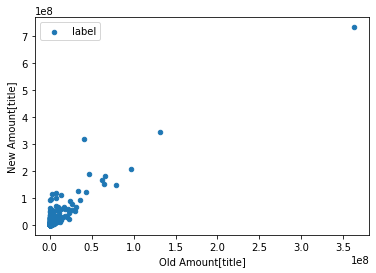

In [8]:
dfCompare=pd.read_excel(os.path.join(cwd_Output,"aacr_dif.xlsx"), engine="openpyxl")
dfCompare=dfCompare[["Gene name","New Amount[title]","Old Amount[title]"]]
dfCompare["dif"]=dfCompare["New Amount[title]"]-dfCompare["Old Amount[title]"]
dfCompare=dfCompare.sort_values(by="dif", ascending=False)
print(dfCompare.head(100))
dfCompare.plot.scatter(x='Old Amount[title]', y='New Amount[title]',label = 'label')
plt.show()